# Biopsy Prostate Cancer Detection - ML

Data in the CSV files:

- **image_id:** ID code for the image.

- **data_provider:** The name of the institution that provided the data. Both the Karolinska Institute and Radboud University Medical Center contributed data. They used different scanners with slightly different maximum microscope resolutions and worked with different pathologists for labeling their images.

- **isup_grade:** Train only. The target variable. The severity of the cancer on a 0-5 scale.

- **gleason_score:** Train only. An alternate cancer severity rating system with more levels than the ISUP scale. For details on how the gleason and ISUP systems compare, see the Additional Resources tab.

 There are two different data providers that clasify the grade of the tumour differently:

**Radboud:** Prostate glands are individually labelled. Valid values are:
- 0: background (non tissue) or unknown
- 1: stroma (connective tissue, non-epithelium tissue)
- 2: healthy (benign) epithelium
- 3: cancerous epithelium (Gleason 3)
- 4: cancerous epithelium (Gleason 4)
- 5: cancerous epithelium (Gleason 5)

**Karolinska:** Regions are labelled. Valid values are:
- 0: background (non tissue) or unknown
- 1: benign tissue (stroma and epithelium combined)
- 2: cancerous tissue (stroma and epithelium combined)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import skimage.io
from skimage.transform import resize, rescale
import cv2
from PIL import Image
import imagecodecs
import random
import matplotlib.image as mpimg
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
train_csv = pd.read_csv('train.csv')

train_csv.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [4]:
train_csv.isna().sum()

image_id         0
data_provider    0
isup_grade       0
gleason_score    0
dtype: int64

In [5]:
train_csv['gleason_score'].value_counts()

3+3         2664
0+0         1921
3+4         1338
4+3         1242
4+4         1123
negative     964
4+5          847
5+4          248
5+5          127
3+5           79
5+3           43
Name: gleason_score, dtype: int64

In [6]:
train_csv['data_provider'].value_counts()

karolinska    5447
radboud       5149
Name: data_provider, dtype: int64

In [7]:
train_csv['isup_grade'].value_counts()

0    2885
1    2664
2    1339
4    1245
3    1241
5    1222
Name: isup_grade, dtype: int64

##### Data in the train CSV seems to be very clean, with same number of rows for each data provider and high number of cases for each isup_grade. 

In [8]:
train_clean = pd.DataFrame()

In [9]:
train_csv['path'] = train_csv['image_id'] +'.png'

In [10]:
train_csv.head()

,image_id,data_provider,isup_grade,gleason_score,path
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0005f7aaab2800f6170c399693a96917.png
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,000920ad0b612851f8e01bcc880d9b3d.png
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,0018ae58b01bdadc8e347995b69f99aa.png
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,001c62abd11fa4b57bf7a6c603a11bb9.png
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,001d865e65ef5d2579c190a0e0350d8f.png


In [11]:
# train_csv['binary_score'] = np.where(
#     (train_csv['data_provider'] == 'karolinska') & (train_csv['isup_grade'] < 2), 'no cancer', 
#     np.where((train_csv['data_provider'] == 'radboud') & (train_csv['isup_grade'] < 3), 'no cancer' , 
#     'cancer'))

train_csv['binary_score'] = np.where((train_csv['isup_grade'] < 1), 'no cancer','cancer')

In [12]:
train_csv.head()

,image_id,data_provider,isup_grade,gleason_score,path,binary_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0005f7aaab2800f6170c399693a96917.png,no cancer
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,000920ad0b612851f8e01bcc880d9b3d.png,no cancer
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,0018ae58b01bdadc8e347995b69f99aa.png,cancer
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,001c62abd11fa4b57bf7a6c603a11bb9.png,cancer
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,001d865e65ef5d2579c190a0e0350d8f.png,no cancer


In [13]:
train_clean = pd.DataFrame(train_csv[['path', 'binary_score']])
train_clean.head()

,path,binary_score
0,0005f7aaab2800f6170c399693a96917.png,no cancer
1,000920ad0b612851f8e01bcc880d9b3d.png,no cancer
2,0018ae58b01bdadc8e347995b69f99aa.png,cancer
3,001c62abd11fa4b57bf7a6c603a11bb9.png,cancer
4,001d865e65ef5d2579c190a0e0350d8f.png,no cancer


In [14]:
#this is for test purposes only
train_clean_small = train_clean[:1000]
train_clean_small

,path,binary_score
0,0005f7aaab2800f6170c399693a96917.png,no cancer
1,000920ad0b612851f8e01bcc880d9b3d.png,no cancer
2,0018ae58b01bdadc8e347995b69f99aa.png,cancer
3,001c62abd11fa4b57bf7a6c603a11bb9.png,cancer
4,001d865e65ef5d2579c190a0e0350d8f.png,no cancer
...,...,...
995,1987d293a6345a3fdfd2accf524bc2d1.png,cancer
996,198fa06f052feedc1684e42829c137fc.png,cancer
997,1990f9eb40f798dcb50f7fad287c0e28.png,cancer
998,19929dc431ae4560780d6a92a8e9fd20.png,cancer


-------------------------------------------------------

# Image treatment

These images are in a .tiff format, which is good for maintaining good quality in the images, but the size is too big fo be feasible to create a model (at least an initial one). I will transform these images into .png and also will convert them to have the same size (512x512), as they have a wide variety of sizes and forms.

In [15]:
# where are the images
data_dir = "train_images/"

In [16]:
# where will the converted images be stored, create the folder if it doesn't exist
save_dir = "png_images/"
os.makedirs(save_dir, exist_ok=True)

In [17]:
# THIS HAS ALREADY BEEN DONE! No need to run it again and again. It converts the images.

# for img_id in tqdm(train_csv.image_id):
#     load_path = data_dir + img_id + '.tiff'
#     save_path = save_dir + img_id + '.png'
    
#     biopsy = skimage.io.MultiImage(load_path)
#     img = cv2.resize(biopsy[-1], (0,0), fx = 0.1, fy = 0.1)
#     cv2.imwrite(save_path, img)

In [18]:
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.2)

In [19]:
train_generator  = datagen.flow_from_dataframe(
    dataframe=train_clean,
    directory=save_dir,
    x_col="path",
    y_col="binary_score",
    target_size=(258, 258),
    color_mode="rgb",
    batch_size=64,
    save_to_dir='png_images_resized/',
    save_format="png",
    class_mode="binary",
    subset='training',
    shuffle = True
)


validation_generator  = datagen.flow_from_dataframe(
    dataframe=train_clean,
    directory=save_dir,
    x_col="path",
    y_col="binary_score",
    target_size=(258, 258),
    color_mode="rgb",
    batch_size=64, #deberia ser mas alto que el del modelo (sugerencia)
    save_to_dir='png_images_resized/',
    save_format="png",
    class_mode="binary",
    subset='validation',
    shuffle = True
)

Found 8477 validated image filenames belonging to 2 classes.
Found 2119 validated image filenames belonging to 2 classes.


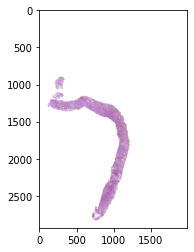

In [20]:
# Now the images are all of the same shape and lighter

files = os.listdir(save_dir)
d = random.choice(files)

img = mpimg.imread(save_dir + d)
imgplot = plt.imshow(img)
plt.show()

In [21]:
# from keras.preprocessing import image

# # reading the training images

# train_image = [ ]

# for i in tqdm(range(train_csv.shape[0])):

#     img = image.load_img('png_images/' + train_csv['image_id'][i] + '.png', target_size = (512,512,1), 
#             grayscale = False)

#     img = image.img_to_array(img)

#     img = img/255

#     train_image.append(img)
#     X = np.array(train_image)

In [22]:
# X.shape

In [23]:
# y = train_csv['isup_grade'].values

In [24]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

----------

# Modeling

In [25]:
import tensorflow as tf
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.4.0
Eager mode:  True
GPU is available


In [26]:
model = tf.keras.Sequential()


model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(258, 258, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))

model.add(tf.keras.layers.Dense(1, activation="sigmoid"))


In [27]:
model.compile(optimizer='adam', 
              loss="binary_crossentropy", 
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0

-----

# Model Training

In [29]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    batch_size=32,
    epochs = 50)

Epoch 1/50
133/133 [==============================] - 597s 4s/step - loss: 0.6070 - accuracy: 0.7050 - val_loss: 0.5585 - val_accuracy: 0.7272
Epoch 2/50
133/133 [==============================] - 581s 4s/step - loss: 0.5766 - accuracy: 0.7231 - val_loss: 0.5356 - val_accuracy: 0.7310
Epoch 3/50
133/133 [==============================] - 577s 4s/step - loss: 0.5315 - accuracy: 0.7384 - val_loss: 0.5456 - val_accuracy: 0.7390
Epoch 4/50
133/133 [==============================] - 578s 4s/step - loss: 0.5656 - accuracy: 0.7371 - val_loss: 0.5013 - val_accuracy: 0.7570
Epoch 5/50
133/133 [==============================] - 580s 4s/step - loss: 0.5090 - accuracy: 0.7594 - val_loss: 0.5512 - val_accuracy: 0.7565
Epoch 6/50
133/133 [==============================] - 579s 4s/step - loss: 0.5077 - accuracy: 0.7567 - val_loss: 0.4900 - val_accuracy: 0.7655
Epoch 7/50
133/133 [==============================] - 579s 4s/step - loss: 0.4623 - accuracy: 0.7787 - val_loss: 0.4803 - val_accuracy: 0.7758

In [30]:
def plot_training(history, metrics: list = ('loss',), figsize: tuple = (12, 5)):
    """
    plots training selected metrics for every batch
    """
    epochs = range(1, len(history.history[metrics[0]]) + 1)

    fig, ax_arr = plt.subplots(1, len(metrics), figsize=figsize)

    if not isinstance(ax_arr, np.ndarray):
        ax_arr = np.array(ax_arr).reshape(1, )

    for i, metric in enumerate(metrics):
        ax_arr[i].plot(epochs, history.history[metric], color='k', linestyle='solid', label=metric, linewidth=2)
        ax_arr[i].plot(epochs, history.history[f"val_{metric}"], color='r', linestyle='dotted',
                       label=f'validation {metric}')
        ax_arr[i].set_ylabel(metric)
        ax_arr[i].set_xlabel('epochs')
        ax_arr[i].grid()
        ax_arr[i].legend()
    plt.show()

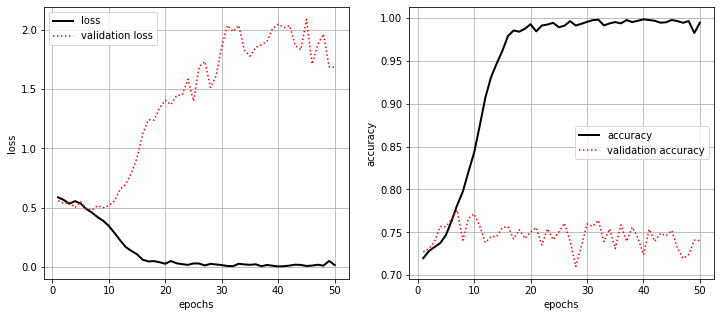

In [31]:
plot_training(history, metrics=['loss', 'accuracy'])

In [32]:
model_name = "first_model_changing_isup_grade"
model.save(os.path.join("model/", f"{model_name}.h5"))

# Model Prediction

In [33]:
img_id = os.listdir('predict/')
img_id[0]

'ffe9bcababc858e04840669e788065a1.tiff'

In [34]:
def image_predict_convert():
    img_id = os.listdir('predict/')
    load_path = 'predict/' + img_id[0]
    save_path = 'predict/png_converted/' + 'predict.png'
    
    biopsy = skimage.io.MultiImage(load_path)
    img = cv2.resize(biopsy[-1], (0,0), fx = 0.1, fy = 0.1)
    cv2.imwrite(save_path, img)
    
image_predict_convert()

In [35]:

model = tf.keras.models.load_model(os.path.join('model/', f"{model_name}.h5"))

In [36]:
def prediction(model, image_path, categories, pixels=258):
    """
    Analyses new cell images given a loaded or just trained model
    :param model: Model to use
    :param image_path: Image to analyse
    :param categories: List. Defined previously
    :param pixels: Image dimension. Default 130
    :return: Shows up the original cell image with a caption, Parasitized or Uninfected
    """
    try:
        img = cv2.imread(image_path)
        resized_img = cv2.resize(img, (pixels, pixels))
    except Exception as e:
        print(f"Error reading file {image_path}")
        exit()

    to_predict = np.array(resized_img).reshape(-1, pixels, pixels, 3)  # 1 grayscale, 3 colored images
    y = model.predict(to_predict)

    # Display results
    result = categories[int(y[0][0])]

    fig, ax = plt.subplots()
    label_font = {"fontname": "Arial", "fontsize": 9}
    plt.imshow(img)
    fig.suptitle(result, fontsize=20)
    ax.set_title(image_path, fontdict=label_font)
    return img, result, image_path

(3072, 691, 3)

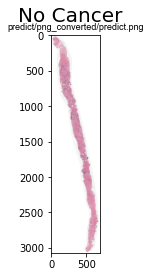

In [39]:
CATEGORIES = ['No Cancer', 'Cancer']
img, result, image_path = prediction(model,image_path= 'predict/png_converted/predict.png', categories = CATEGORIES)

img.shape

In [33]:
# test_loss, test_accuracy = model.evaluate(X_test, y_test)

In [34]:
# Same for label masks 
# data_masks_dir = "train_label_masks/"

In [35]:
# save_mask_dir = "png_masks/"
# os.makedirs(save_maks_dir, exist_ok=True)

# mask_files = os.listdir(data_masks_dir)

In [36]:
# for mask_file in tqdm(mask_files):
#     load_path = data_masks_dir + mask_file
#     save_path = save_mask_dir + mask_file.replace('.tiff', '.png')
    
#     mask = skimage.io.MultiImage(load_path)
#     img = cv2.resize(mask[-1], (512, 512))
#     cv2.imwrite(save_path, img)